In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import webdataset as wds
import wids

# OCR Evaluation

This is a small repository containing code for measuring error rates of OCR systems.

OCR output and ground truth are assumed to be in hOCR format, Markdown, or plain text format.

Collections of pages and text files are assumed to be in WebDataset format (meaning, .tar archives with related files grouped together by name.)

Two evaluations are possible:

- text based evaluation performs a rough estimate of a block move edit distance
- bounding box based evaluation puts OCR and ground truth into correspondence using geometric information

Both evaluation methods use heuristics to arrive at error estimates. Nevertheless, they should be good enough to assess the relative performance of different OCR engines.

# Evaluation Dataset

We start with a small evaluation dataset of 100 pages stored in a tar archive (with WebDataset conventions).

In [2]:
!tar tvf testdata/ocr-eval-hocr.tar | head

-r--r--r-- bigdata/bigdata 17282 2023-12-22 10:39 E00P.hocr.html
-r--r--r-- bigdata/bigdata 3779135 2023-12-22 10:39 E00P.page.jpg
-r--r--r-- bigdata/bigdata   16740 2023-12-22 10:39 W188.hocr.html
-r--r--r-- bigdata/bigdata 3763997 2023-12-22 10:39 W188.page.jpg
-r--r--r-- bigdata/bigdata   18454 2023-12-22 10:39 W030.hocr.html
-r--r--r-- bigdata/bigdata 4049422 2023-12-22 10:39 W030.page.jpg
-r--r--r-- bigdata/bigdata    7642 2023-12-22 10:39 N026.hocr.html
-r--r--r-- bigdata/bigdata 1617937 2023-12-22 10:39 N026.page.jpg
-r--r--r-- bigdata/bigdata   15867 2023-12-22 10:39 C00J.hocr.html
-r--r--r-- bigdata/bigdata 3541891 2023-12-22 10:39 C00J.page.jpg
tar: stdout: write error


Looking at the images, we notice that there are page frames and (on some page) even text from opposing sides. This hinders OCR error evaluation.

[{'url': 'testdata/ocr-eval-hocr.tar', 'nsamples': base: None name: None nfiles: 1 nbytes: 0 samples: 100 cache: /tmp/_wids_cache


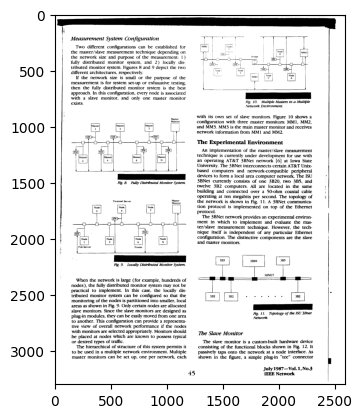

In [3]:
raw = wids.ShardListDataset([dict(url="testdata/ocr-eval-hocr.tar", nsamples=100)])
plt.imshow(raw[66][".page.jpg"], cmap="gray")

To remove the page frame, we run the `runocr reframe` command. This command infers a text bounding box from the hOCR ground truth and masks out any content outside that bounding box.

In [4]:
!runocr reframe testdata/ocr-eval-hocr.tar --output ocr-eval-hocr-reframed.tar --hocr hocr.html --img page.jpg

E00P 326 506 2422 3240
W188 408 281 2171 3140
W030 178 123 2334 3145
N026 640 519 2528 3191
C00J 255 217 2401 3204
C001 248 80 2353 3027
W1K0 396 562 2216 3115
W143 346 146 2492 3157
A00G 779 242 2314 2537
H013 320 503 2229 3128
S02G 123 37 2364 3248
E04P 114 104 2263 3120
W093 268 309 2313 3070
J004 751 676 2069 2870
W0I7 238 205 2159 3116
W13B 149 99 2315 3115
D05N 543 833 1901 3128
K003 275 248 2423 3248
W1J6 378 192 2312 3092
W087 298 189 2049 3042
N02F 425 380 2229 2839
S00G 125 130 2024 2766
W0I4 300 1126 2216 3089
N03C 141 160 2288 3086
W1I1 375 263 2303 3176
E03G 817 710 2472 3179
S035 193 66 1861 2890
W1P5 229 995 2335 3134
A04A 406 799 1852 2472
W0A9 221 2065 2280 3153
J00I 523 576 2058 3165
E044 146 208 1808 2852
W1S7 458 347 2268 3178
D036 455 194 2028 2602
H00I 553 458 2056 2835
W1IJ 355 269 2292 3181
J030 362 176 2364 3052
D054 410 200 2112 2863
D06K 194 191 2351 3213
W1C4 348 903 1973 3133
H00R 575 660 2084 3124
H000 728 755 2079 3120
C048 201 114 2443 3211
N059 591 481 

[{'url': 'ocr-eval-hocr-reframed.tar', 'nsamples': base: None name: None nfiles: 1 nbytes: 0 samples: 100 cache: /tmp/_wids_cache


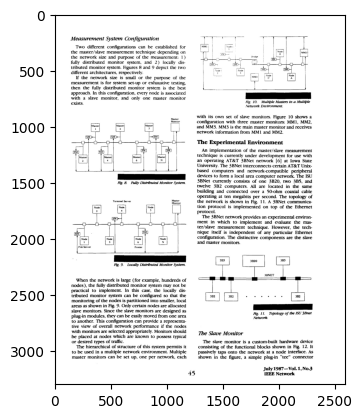

In [5]:
reframed = wids.ShardListDataset([dict(url="ocr-eval-hocr-reframed.tar", nsamples=100)])
plt.imshow(reframed[66][".page.jpg"], cmap="gray")

# Running OCR

The `runocr runocr` command runs the Tesseract OCR engine over the page images in the input shard.

In [6]:
!runocr runocr ocr-eval-hocr-reframed.tar --output ocr-eval-hocr-reframed-ocr.tar 

# cd /tmp/tmpsa4i3s7q && tesseract page.jpg output hocr
Tesseract Open Source OCR Engine v4.1.1 with Leptonica
Estimating resolution as 343
E00P 0; x_wconf 96\'>TECHNOLOGY</span>\n     </span>\n    </p>\n   </div>\n  </div>\n </body>\n</html>\n'
# cd /tmp/tmpaulta5vw && tesseract page.jpg output hocr
Tesseract Open Source OCR Engine v4.1.1 with Leptonica
Estimating resolution as 338
W188 9 3136; x_wconf 96\'>image</span>\n     </span>\n    </p>\n   </div>\n  </div>\n </body>\n</html>\n'
# cd /tmp/tmpuejjb_ho && tesseract page.jpg output hocr
Tesseract Open Source OCR Engine v4.1.1 with Leptonica
Estimating resolution as 316
Detected 21 diacritics
W030 82 3144; x_wconf 95\'>IEEE</span>\n     </span>\n    </p>\n   </div>\n  </div>\n </body>\n</html>\n'
# cd /tmp/tmp4kl0saky && tesseract page.jpg output hocr
Tesseract Open Source OCR Engine v4.1.1 with Leptonica
Estimating resolution as 395
N026 1626 3187; x_wconf 96\'>81</span>\n     </span>\n    </p>\n   </div>\n  </div>\n </body>\n</ht

In [7]:
!tar tvf ocr-eval-hocr-reframed-ocr.tar | head

-r--r--r-- bigdata/bigdata 17282 2023-12-23 00:06 E00P.hocr.html
-r--r--r-- bigdata/bigdata 3693490 2023-12-23 00:06 E00P.page.jpg
-r--r--r-- bigdata/bigdata  101312 2023-12-23 00:06 E00P.tess.html
-r--r--r-- bigdata/bigdata   16740 2023-12-23 00:07 W188.hocr.html
-r--r--r-- bigdata/bigdata 3535616 2023-12-23 00:07 W188.page.jpg
-r--r--r-- bigdata/bigdata  118098 2023-12-23 00:07 W188.tess.html
-r--r--r-- bigdata/bigdata   18454 2023-12-23 00:07 W030.hocr.html
-r--r--r-- bigdata/bigdata 3999421 2023-12-23 00:07 W030.page.jpg
-r--r--r-- bigdata/bigdata  117053 2023-12-23 00:07 W030.tess.html
-r--r--r-- bigdata/bigdata    7642 2023-12-23 00:07 N026.hocr.html
tar: stdout: write error


# OCR Error Evaluation using Text

To evaluate OCR results, we need to compare the ground truth text against the output of the OCR engine.

There are three ways of doing this:

1. If the OCR results and ground truth are contained in the same shard, you can just run `ocrtexteval evalocr` on the shard(s)
2. If the OCR results and ground truth are contained in different shards but are in the same order, you can zip them together using the `--gtshard` argument to `evalocr`.
3. If the OCR results are in a different order from the ground truth, you can load the ground truth into a database with `loadgt` and then use `--gtdb` for evaluation.

Here, we kept ground truth and OCR results together in the same shard, so we can use (1).

Output from `evalocr` is always in the form of an sqlite3 database.

In [8]:
!tar tvf ocr-eval-hocr-reframed-ocr.tar | sed 5q

-r--r--r-- bigdata/bigdata 17282 2023-12-23 00:06 E00P.hocr.html
-r--r--r-- bigdata/bigdata 3693490 2023-12-23 00:06 E00P.page.jpg
-r--r--r-- bigdata/bigdata  101312 2023-12-23 00:06 E00P.tess.html
-r--r--r-- bigdata/bigdata   16740 2023-12-23 00:07 W188.hocr.html
-r--r--r-- bigdata/bigdata 3535616 2023-12-23 00:07 W188.page.jpg
tar: stdout: write error


In [9]:
!rm -f ocr_eval.db
!ocrtexteval texteval ocr-eval-hocr-reframed-ocr.tar --gtkey hocr.html --ocrkey tess.html --output ocr_eval.db

0 E00P 0.002426564495530013 0.004279661016949153 0
1 W188 0.005078494420276148 0.007105263157894736 0
2 W030 0.0051295518207282904 0.009600694444444445 5
3 N026 0.01188063063063063 0.022115384615384617 0
4 C00J 0.002943589743589744 0.004816326530612245 0
5 C001 0.006903633491311217 0.008317610062893081 7
6 W1K0 0.0028578528827037774 0.009485294117647059 0
7 W143 0.026009316770186336 0.02958515283842795 7
8 A00G 0.02299107142857143 0.02388888888888889 1
9 H013 0.03125267208208636 0.0419375 4
10 S02G 0.018399913156752063 0.026319148936170215 4
11 E04P 0.016867852604828464 0.019170168067226892 4
12 W093 0.002830641292179754 0.006047619047619048 0
13 J004 0.0027561102444097763 0.011122448979591837 0
14 W0I7 0.0055853920515574655 0.006203208556149732 0
15 W13B 0.002047813194959229 0.003136531365313653 0
16 D05N 0.025121951219512197 0.03773529411764706 2
17 K003 0.014623955431754874 0.012686567164179107 17
18 W1J6 0.005410225921521999 0.008549528301886792 0
19 W087 0.005618300153139357 0.008

In [10]:
import pandas as pd
import sqlite3

db = sqlite3.connect('ocr_eval.db')
df = pd.read_sql_query("SELECT * FROM ocr_eval", db)

# A good overall estimate of the character error rate is the maximum of the
# forward and reverse character error rates.
df['allerr'] = df[['err', 'rerr']].max(axis=1)

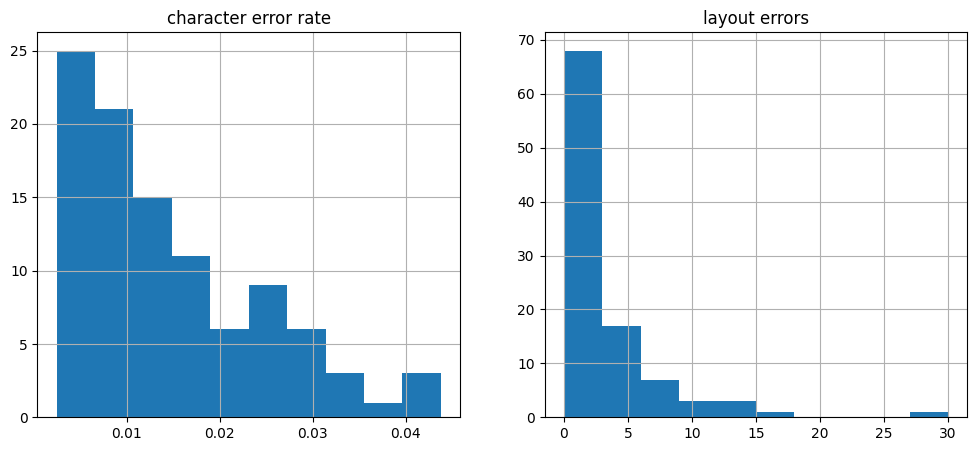

In [11]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.title("character error rate")
df.allerr.hist(bins=10)
plt.subplot(122)
plt.title("layout errors")
df.layout_err.hist(bins=10);

# OCR Error Evaluation using Bounding Boxes

The above error computation operates purely on the text in the ground truth and by the OCR system.

We can also evaluate OCR systems by taking into account bounding box information. This looks for corresponding bounding boxes in the ground truth and OCR results and then compare the text associated with those bounding boxes.

This really only works well with `ocrx_word` elements, however, the dataset we're using here only contains `ocr_line`, so that's what we are using for the evaluation here. But that's also why these error rates don't correspond particularly well to the text based evaluation.

Evaluation with bounding boxes returns three metrics:

- the error rate of ground truth boxes matched by OCR output
- the number of ground truth boxes not matched by any OCR box
- the number of OCR output boxes not matched by ground truth

In [12]:
!rm -f bb_eval.db
!ocrtexteval bboxeval ocr-eval-hocr-reframed-ocr.tar --element ocr_line

0 E00P 3 4573 0 0
1 W188 47 5205 0 1
2 W030 278 5651 0 6
3 N026 28 1776 0 0
4 C00J 20 4780 0 0
5 C001 77 3128 3 3
6 W1K0 249 1985 1 10
7 W143 174 4504 6 2
8 A00G 7 873 2 0
9 H013 117 2356 2 0
10 S02G 174 4596 4 2
11 E04P 69 4678 5 1
12 W093 23 6169 0 0
13 J004 14 1926 1 1
14 W0I7 48 3650 5 2
15 W13B 1 5316 1 0
16 D05N 36 1656 0 0
17 K003 208 3915 8 1
18 W1J6 76 4155 0 2
19 W087 60 5152 0 1
20 N02F 77 1695 7 0
21 S00G 397 4300 0 0
22 W0I4 4 3048 0 1
23 N03C 215 1749 1 2
24 W1I1 4 4178 16 1
25 E03G 671 3003 2 10
26 S035 83 4352 0 0
27 W1P5 40 3936 5 1
28 A04A 43 1899 0 0
29 W0A9 29 2115 0 1
30 J00I 13 1380 0 2
31 E044 52 3880 0 0
32 W1S7 0 3256 0 0
33 D036 71 2533 1 0
34 H00I 41 2870 0 0
35 W1IJ 228 3813 0 1
36 J030 90 4473 1 3
37 D054 169 3248 0 0
38 D06K 24 5829 0 1
39 W1C4 22 3572 10 0
40 H00R 80 2424 1 0
41 H000 138 1942 1 0
42 C048 777 3394 5 9
43 N059 12 3313 0 0
44 W016 189 5688 3 2
45 W0T1 62 3321 0 0
46 W102 85 3641 1 1
47 W1S5 0 3101 0 0
48 A00O 121 6010 0 1
49 W0G5 9 5744 3 1


In [13]:
db = sqlite3.connect('bb_eval.db')
df2 = pd.read_sql_query("SELECT * FROM bb_eval", db)
df2["err"] = df2.errors / df2.total
df2["layout_errs"] = df2.missing_ocr + df2.extra_ocr

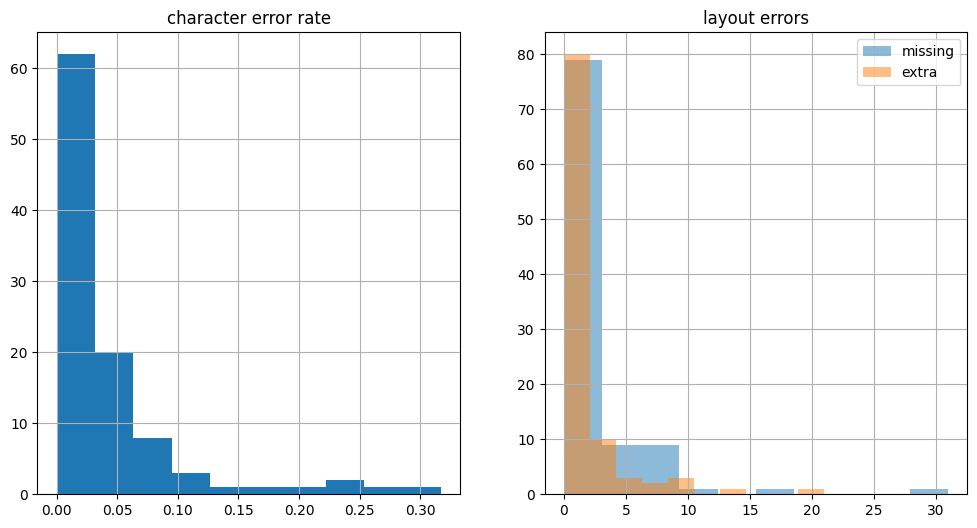

In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("character error rate")
(df2.errors/df2.total).hist(bins=10)
plt.subplot(122)
plt.title("layout errors")
df2.missing_ocr.hist(bins=10, alpha=0.5, label="missing");
df2.extra_ocr.hist(bins=10, alpha=0.5, label="extra");
plt.legend();

We can look at the correlation between the text based estimate and the bounding box based estimate. Because we used `ocr_line` as the element, small errors in bounding boxes turn into large increases in error rates. On the other hand, the text based error rate estimates are somewhat more lenient than those based on bounding boxes.

For actual production use, either use the text-based error rate estimate, or the bounding box estimate with `ocrx_word` elements.

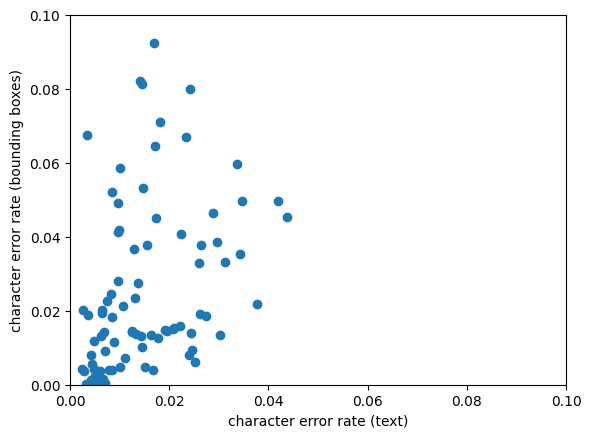

In [15]:
plt.scatter(df.allerr, df2.err)
plt.xlim(0, 0.1)
plt.ylim(0, 0.1)
plt.xlabel("character error rate (text)")
plt.ylabel("character error rate (bounding boxes)");